# Modeling Barn Owl Ears with a Neural Network
### Ben Ries-Roncalli



In this project we will create a neural network mimicking barn owl ears. Based on features of an input sound (i.e. the delay between the ears hearing the noise), the neural network will predict the source direction of the noise. We will assess how this neural network performs on both clean and noisy training and test data, to assess its susceptibility to noisy data.

$\rightarrow$ Import necessary libraries and read in the data.

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rand # for introducing noise w/ Poisson random distribution
import matplotlib.pyplot as plt # for visualizations
import seaborn as sns # for visualizations
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split # for splitting train & test data
from sklearn.neural_network import MLPRegressor # for neural network
from sklearn.metrics import mean_squared_error # for computing RMSE

num_input_neurons = 10500

column_names = [f"activation #{i + 1}" for i in range(num_input_neurons)]
column_names.append("Azimuth")
column_names.append("Elevation")

df = pd.read_csv("input_features.csv", header=None, names=column_names)
df

,activation #1,activation #2,activation #3,activation #4,activation #5,activation #6,activation #7,activation #8,activation #9,activation #10,...,activation #10493,activation #10494,activation #10495,activation #10496,activation #10497,activation #10498,activation #10499,activation #10500,Azimuth,Elevation
0,0.011800,0.008190,0.000755,0.000206,0.000440,2.630000e-03,1.590000e-03,0.005690,0.018000,0.040500,...,0.0420,0.02200,0.04540,0.0382,0.000002,0.01630,0.002750,6.700000e-07,-90.0,0.0
1,0.014500,0.011100,0.000947,0.000365,0.000203,2.070000e-03,2.190000e-03,0.004020,0.012800,0.039800,...,0.0286,0.02240,0.05540,0.0457,0.000282,0.02060,0.003960,3.090000e-06,-85.0,-5.0
2,0.011800,0.008070,0.000653,0.000306,0.000117,1.380000e-03,9.570000e-04,0.005130,0.016800,0.034900,...,0.0259,0.02680,0.03000,0.0625,0.001530,0.01380,0.003750,1.630000e-05,-85.0,0.0
3,0.013700,0.006920,0.000410,0.000336,0.000657,2.000000e-03,2.370000e-03,0.012500,0.032200,0.049700,...,0.0618,0.00957,0.04480,0.0424,0.000074,0.00790,0.001340,3.330000e-08,-85.0,5.0
4,0.018100,0.012000,0.001060,0.000479,0.000054,2.290000e-03,3.440000e-03,0.005680,0.008970,0.041600,...,0.0195,0.02080,0.05320,0.0425,0.000610,0.01250,0.006160,8.710000e-06,-80.0,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,0.000014,0.000335,0.000825,0.000376,0.001860,9.090000e-07,2.210000e-06,0.000238,0.000942,0.006130,...,0.0498,0.02200,0.04880,0.4130,0.150000,0.00776,0.000023,1.190000e-06,80.0,10.0
681,0.000008,0.000294,0.002550,0.000882,0.026600,3.280000e-03,6.610000e-07,0.008610,0.000069,0.000767,...,0.0280,0.00786,0.00382,0.0212,0.042200,0.01080,0.002420,5.490000e-03,85.0,-5.0
682,0.000010,0.000379,0.001640,0.002030,0.019600,2.630000e-03,5.480000e-06,0.001850,0.000157,0.001930,...,0.0294,0.00646,0.00368,0.0309,0.080900,0.03680,0.007280,1.510000e-03,85.0,0.0
683,0.000010,0.000381,0.001330,0.000787,0.004270,3.340000e-04,3.470000e-06,0.000100,0.000200,0.002000,...,0.0406,0.01050,0.02500,0.0822,0.257000,0.09320,0.000047,1.060000e-04,85.0,5.0


$\rightarrow$ Convert the data frame into arrays of the inputs ($X$) and outputs ($y$) of the neural network.

In [2]:
y = np.array(df[['Azimuth', 'Elevation']])
X = np.array(df.drop(columns=['Azimuth', 'Elevation']))

$\rightarrow$ Define some functions to add noise to signals with a Poisson random distribution.

In [3]:
def Noisifier(R, scaler):
  scaledR = scaler*R
  # add variability to scaled neuron response using poisson random variable
  rng = rand.default_rng()
  poisson_noise_plus = rng.poisson(5, R.shape)
  poisson_noise_minus = rng.poisson(5, R.shape)
  scaledR += poisson_noise_plus
  scaledR -= poisson_noise_minus

  for i in range(R.shape[0]):
    if scaledR[i] < 0:
      scaledR[i] = 0
    elif scaledR[i] > scaler:
      scaledR[i] = scaler
  
  return scaledR / scaler


def NoisyRVecs(X_train, scaler):
  noisy_x_train = X_train.copy()
  for i in range(noisy_x_train.shape[0]):
    noisy_x_train[i,:] = Noisifier(noisy_x_train[i,:], scaler)
  return noisy_x_train

$\rightarrow$ Visualize some examples of clean and noisy signals.

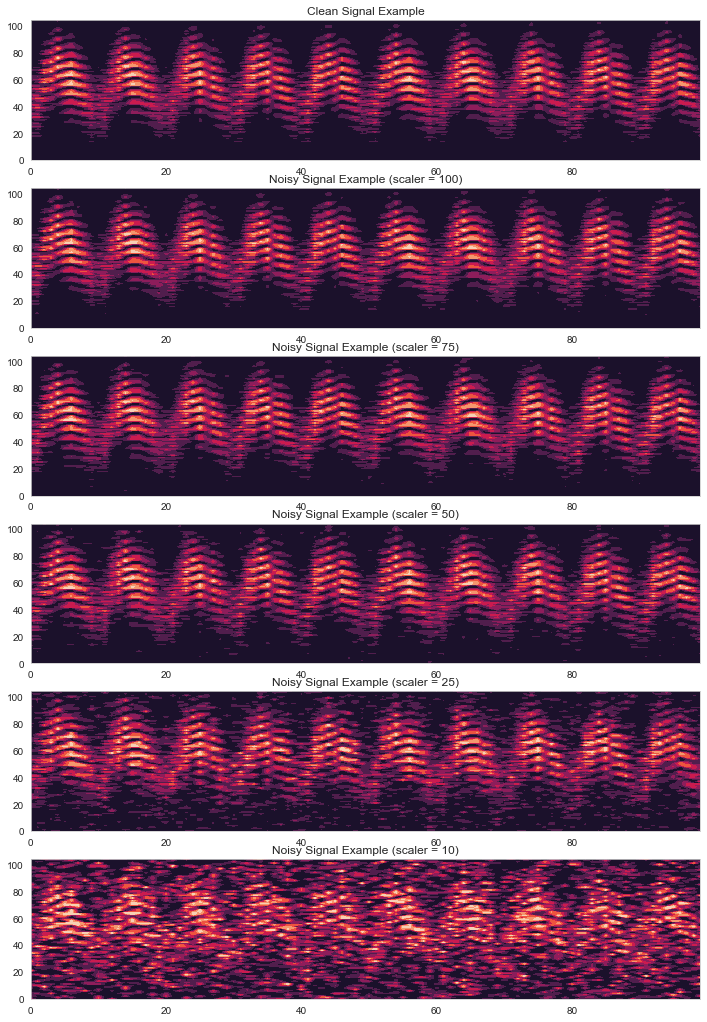

In [4]:
plt.subplots(6, 1, figsize = (12,18))
plt.subplot(6,1,1)
plt.contourf(X[1,:].reshape(105,100))
plt.title("Clean Signal Example")

i = 2
for n in [100, 75, 50, 25, 10]:
  plt.subplot(6,1,i)
  NoisyX = NoisyRVecs(X, n)
  plt.title("Noisy Signal Example (scaler = %i)" %n)
  plt.contourf(NoisyX[1,:].reshape(105,100))
  i+=1
  

$\rightarrow$ Split the data into training and data.

When we create the noisy data, we display the RMSE between the train and test data to show the difference in signal. Note that since entries must be between 0 and 1, the RMSE could also be interpreted as a percent noise in the signal

In [5]:
# do an 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

# create noisy versions of the data at two levels
noisy10_X_train = NoisyRVecs(X_train, 10)
print('X_train RMSE with scaler = 10: %f' % round(mean_squared_error(X_train, noisy10_X_train, squared=False),4))
noisy10_X_test = NoisyRVecs(X_test, 10)
print('X_test RMSE with scaler = 10: %f \n' % round(mean_squared_error(X_train, noisy10_X_train, squared=False),4))

noisy25_X_train = NoisyRVecs(X_train, 25)
print('X_train RMSE with scaler = 25: %f' % round(mean_squared_error(X_train, noisy25_X_train, squared=False),4))
noisy25_X_test = NoisyRVecs(X_test, 25)
print('X_test RMSE with scaler = 25: %f \n' % round(mean_squared_error(X_train, noisy25_X_train, squared=False),4))

noisy50_X_train = NoisyRVecs(X_train, 50)
print('X_train RMSE with scaler = 50: %f' % round(mean_squared_error(X_train, noisy50_X_train, squared=False),4))
noisy50_X_test = NoisyRVecs(X_test, 50)
print('X_test RMSE with scaler = 50: %f \n' % round(mean_squared_error(X_train, noisy50_X_train, squared=False),4))

noisy75_X_train = NoisyRVecs(X_train, 75)
print('X_train RMSE with scaler = 75: %f' % round(mean_squared_error(X_train, noisy75_X_train, squared=False),4))
noisy75_X_test = NoisyRVecs(X_test, 75)
print('X_test RMSE with scaler = 75: %f \n' % round(mean_squared_error(X_train, noisy75_X_train, squared=False),4))

noisy100_X_train = NoisyRVecs(X_train, 100)
print('X_train RMSE with scaler = 100: %f' % round(mean_squared_error(X_train, noisy100_X_train, squared=False),4))
noisy100_X_test = NoisyRVecs(X_test, 100)
print('X_test RMSE with scaler = 100: %f \n' % round(mean_squared_error(X_train, noisy100_X_train, squared=False),4))

X_train RMSE with scaler = 10: 0.236700
X_test RMSE with scaler = 10: 0.236700 

X_train RMSE with scaler = 25: 0.102400
X_test RMSE with scaler = 25: 0.102400 

X_train RMSE with scaler = 50: 0.053400
X_test RMSE with scaler = 50: 0.053400 

X_train RMSE with scaler = 75: 0.036300
X_test RMSE with scaler = 75: 0.036300 

X_train RMSE with scaler = 100: 0.027600
X_test RMSE with scaler = 100: 0.027600 



Note that a larger value for `scaler` in the Noise functions results in a smaller amount of noise.

$\rightarrow$ Train a neural network on the clean signal. (~40 seconds runtime)

In [6]:
cleanNN = MLPRegressor(max_iter = 10000).fit(X_train, y_train)

$\rightarrow$ Define functions to help with visualizations of predictions and computing accuracy.

In [7]:
def PredictionVisualizer(pred, y, subplot_title):
    plt.subplots(1,2, figsize = (8,4))
    plt.suptitle(subplot_title, fontsize=16)
    
    plt.subplot(1,2,1)
    plt.plot(y[:,0], pred[:,0],'o', alpha = 0.4)
    plt.xlabel('True Azimuth (deg)', fontsize = 15)
    plt.ylabel('Estimated Azimuth (deg)', fontsize = 15)

    plt.subplot(1,2,2)
    plt.plot(y[:,1], pred[:,1],'o', alpha = 0.4)
    plt.xlabel('True Elevation (deg)', fontsize = 15)
    plt.ylabel('Estimated Elevation (deg)', fontsize = 15)
    plt.show()


def rmse_Printer(pred, y, print_rmse):
    rmse = [round(mean_squared_error(y[:,i], pred[:,i], squared=False),4) for i in range(0,2)]
    
    if print_rmse:
        print("Azimuth RMSE: %f" % rmse[0])
        print("Elevation RMSE: %f" % rmse[1])
    
    return rmse

def PerformanceVisualizer(model, x, y, scaler):
    pred = model.predict(x)
    if scaler == 0:
        PredictionVisualizer(pred, y, 'Performance on clean training data')
    else:
        PredictionVisualizer(pred, y, 'Performance on noisy training data (scaler = %i)' % scaler)
        
    rmse_Printer(pred, y, True)
    

$\rightarrow$ Analyze the performance of the model trained on clean data on the training data with different levels of noise introduced.

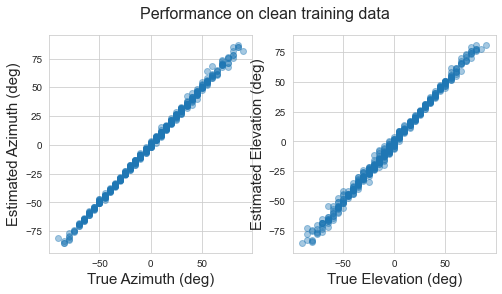

Azimuth RMSE: 1.670400
Elevation RMSE: 2.594100



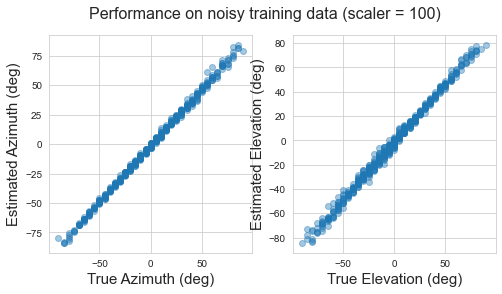

Azimuth RMSE: 2.567900
Elevation RMSE: 3.337500



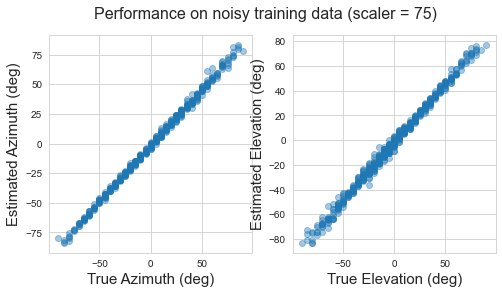

Azimuth RMSE: 3.135400
Elevation RMSE: 3.767500



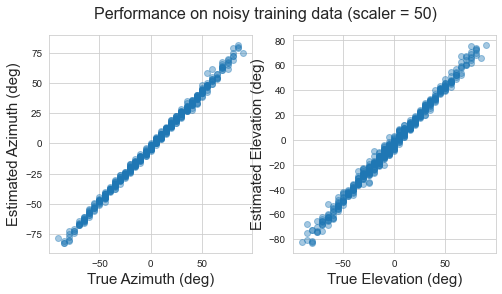

Azimuth RMSE: 4.644400
Elevation RMSE: 4.944500



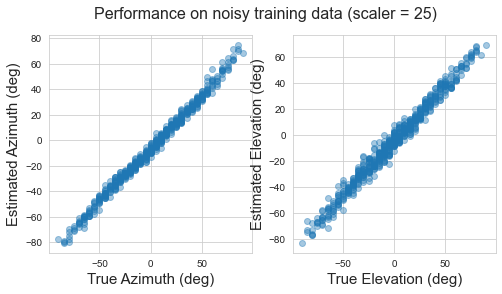

Azimuth RMSE: 9.295000
Elevation RMSE: 8.528300



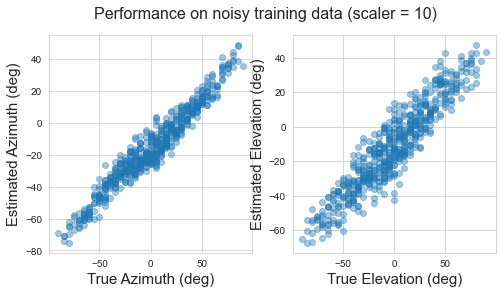

Azimuth RMSE: 22.538600
Elevation RMSE: 19.901700



In [8]:
# predictions on clean training data (what it was trained on)
PerformanceVisualizer(cleanNN, X_train, y_train, 0)
print()

# predictions on noisy100 training data
PerformanceVisualizer(cleanNN, noisy100_X_train, y_train, 100)
print()

# predictions on noisy75 training data
PerformanceVisualizer(cleanNN, noisy75_X_train, y_train, 75)
print()

# predictions on noisy50 training data
PerformanceVisualizer(cleanNN, noisy50_X_train, y_train, 50)
print()

# predictions on noisy25 training data
PerformanceVisualizer(cleanNN, noisy25_X_train, y_train, 25)
print()

# predictions on noisy10 training data
PerformanceVisualizer(cleanNN, noisy10_X_train, y_train, 10)
print()

$\rightarrow$ Analyze the performance of the model trained on clean data on test data with different levels of noise introduced.

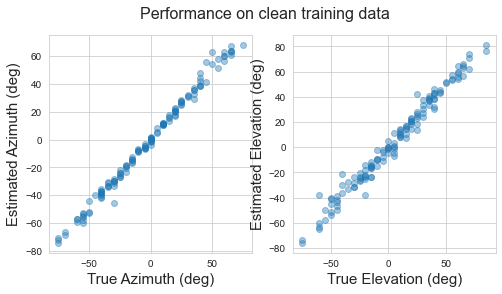

Azimuth RMSE: 3.064600
Elevation RMSE: 5.396200



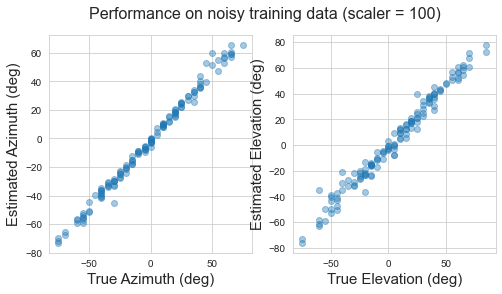

Azimuth RMSE: 3.436100
Elevation RMSE: 5.918900



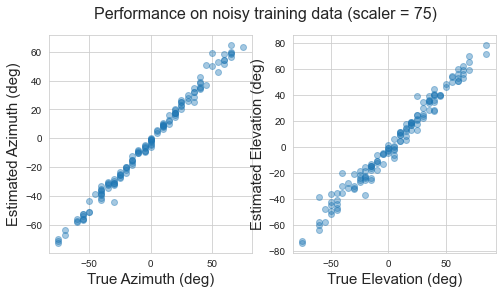

Azimuth RMSE: 3.769200
Elevation RMSE: 6.121200



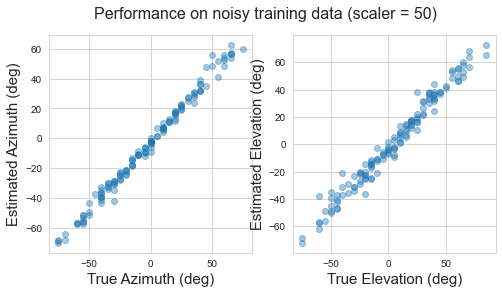

Azimuth RMSE: 4.822700
Elevation RMSE: 7.181600



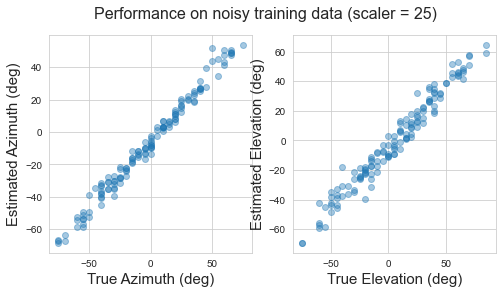

Azimuth RMSE: 8.621000
Elevation RMSE: 10.460900



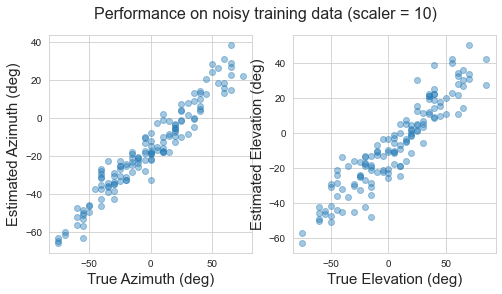

Azimuth RMSE: 21.288100
Elevation RMSE: 20.906800



In [9]:
# predictions on clean testing data (what it was trained on)
PerformanceVisualizer(cleanNN, X_test, y_test, 0)
print()

# predictions on noisy100 testing data
PerformanceVisualizer(cleanNN, noisy100_X_test, y_test, 100)
print()

# predictions on noisy75 testing data
PerformanceVisualizer(cleanNN, noisy75_X_test, y_test, 75)
print()

# predictions on noisy50 testing data
PerformanceVisualizer(cleanNN, noisy50_X_test, y_test, 50)
print()

# predictions on noisy25 testing data
PerformanceVisualizer(cleanNN, noisy25_X_test, y_test, 25)
print()

# predictions on noisy10 testing data
PerformanceVisualizer(cleanNN, noisy10_X_test, y_test, 10)
print()

$\rightarrow$ Train a neural network on noisy100 training data.

In [10]:
noisy100NN = MLPRegressor(max_iter = 10000).fit(noisy100_X_train, y_train)

$\rightarrow$ Analyze the performance of the model trained on noisy100 on training data with different levels of noise introduced.

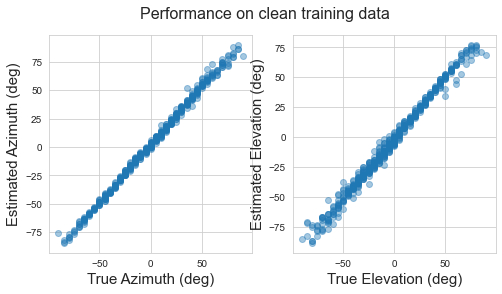

Azimuth RMSE: 3.425500
Elevation RMSE: 4.130700



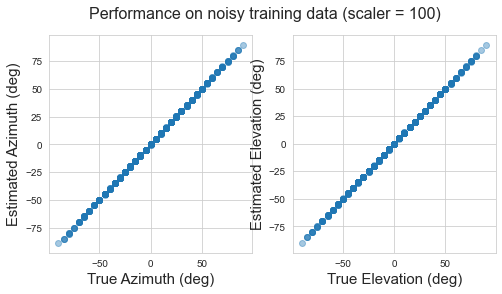

Azimuth RMSE: 0.158000
Elevation RMSE: 0.133200



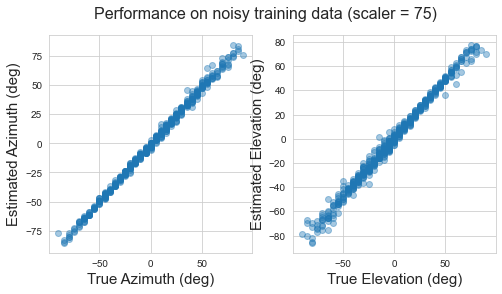

Azimuth RMSE: 2.511000
Elevation RMSE: 3.958300



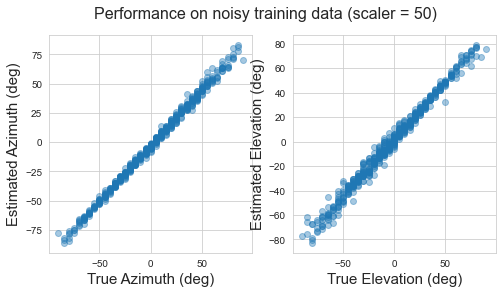

Azimuth RMSE: 4.196900
Elevation RMSE: 5.168100



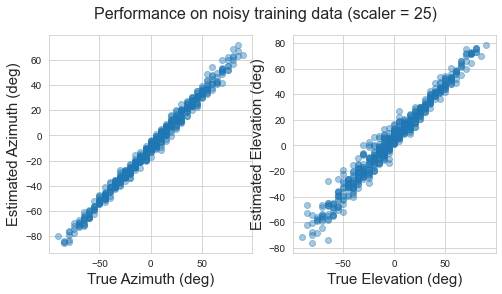

Azimuth RMSE: 11.062500
Elevation RMSE: 10.270700



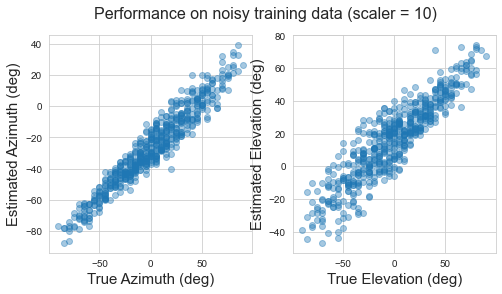

Azimuth RMSE: 31.342900
Elevation RMSE: 26.102100



In [11]:
# predictions on clean training data
PerformanceVisualizer(noisy100NN, X_train, y_train, 0)
print()

# predictions on noisy100 training data (what it was trained on)
PerformanceVisualizer(noisy100NN, noisy100_X_train, y_train, 100)
print()

# predictions on noisy75 training data
PerformanceVisualizer(noisy100NN, noisy75_X_train, y_train, 75)
print()

# predictions on noisy50 training data
PerformanceVisualizer(noisy100NN, noisy50_X_train, y_train, 50)
print()

# predictions on noisy25 training data
PerformanceVisualizer(noisy100NN, noisy25_X_train, y_train, 25)
print()

# predictions on noisy10 training data
PerformanceVisualizer(noisy100NN, noisy10_X_train, y_train, 10)
print()

$\rightarrow$ Analyze the performance of the model trained on noisy100 data on test data with different levels of noise introduced.

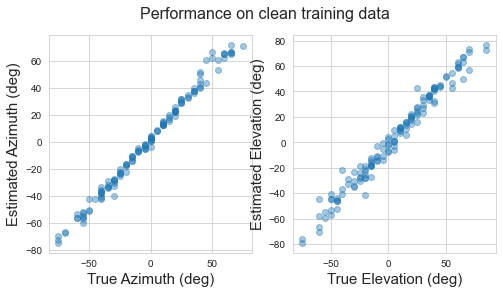

Azimuth RMSE: 4.283400
Elevation RMSE: 5.723900



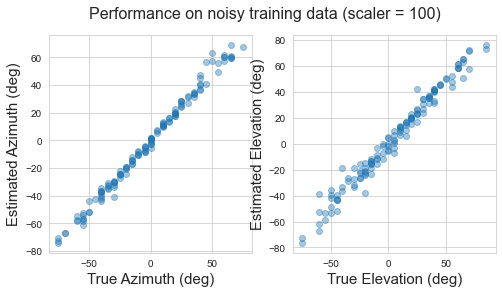

Azimuth RMSE: 3.240800
Elevation RMSE: 5.774300



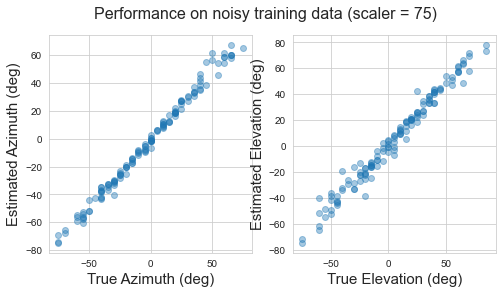

Azimuth RMSE: 3.364700
Elevation RMSE: 5.755800



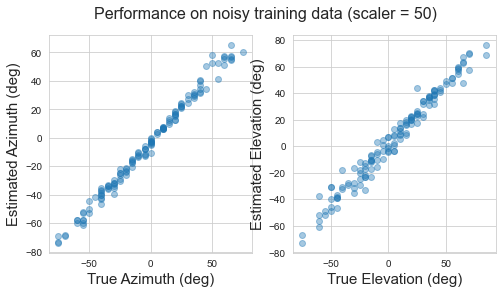

Azimuth RMSE: 4.498700
Elevation RMSE: 6.771900



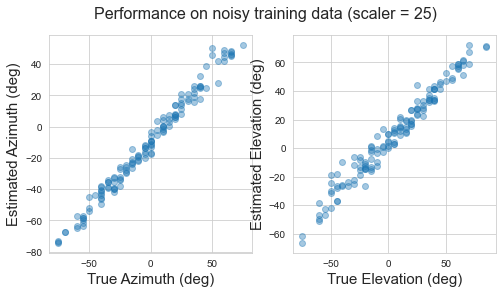

Azimuth RMSE: 10.501400
Elevation RMSE: 9.926200



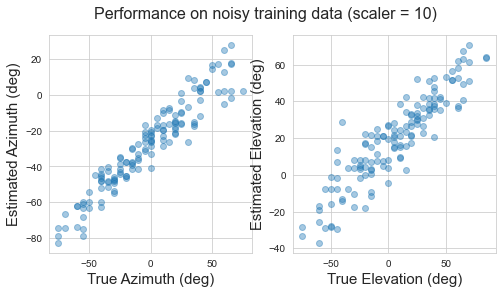

Azimuth RMSE: 29.767400
Elevation RMSE: 22.903100



In [12]:
# predictions on clean testing data 
PerformanceVisualizer(noisy100NN, X_test, y_test, 0)
print()

# predictions on noisy100 testing data (what it was trained on)
PerformanceVisualizer(noisy100NN, noisy100_X_test, y_test, 100)
print()

# predictions on noisy75 testing data
PerformanceVisualizer(noisy100NN, noisy75_X_test, y_test, 75)
print()

# predictions on noisy50 testing data
PerformanceVisualizer(noisy100NN, noisy50_X_test, y_test, 50)
print()

# predictions on noisy25 testing data
PerformanceVisualizer(noisy100NN, noisy25_X_test, y_test, 25)
print()

# predictions on noisy10 testing data
PerformanceVisualizer(noisy100NN, noisy10_X_test, y_test, 10)
print()

$\rightarrow$ Train a neural network on noisy75 training data.

In [13]:
noisy75NN = MLPRegressor(max_iter = 10000).fit(noisy75_X_train, y_train)

$\rightarrow$ Analyze the performance of the model trained on noisy75 on training data with different levels of noise introduced.

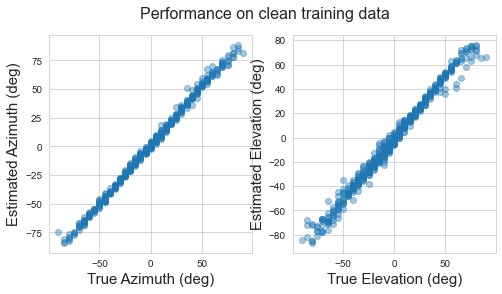

Azimuth RMSE: 2.823400
Elevation RMSE: 4.304100



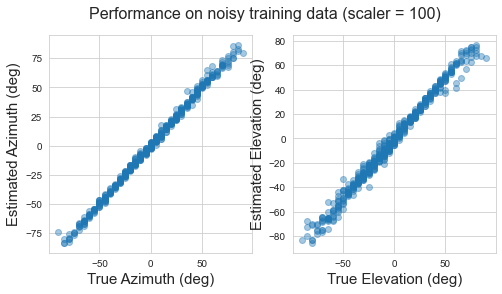

Azimuth RMSE: 2.251900
Elevation RMSE: 4.130300



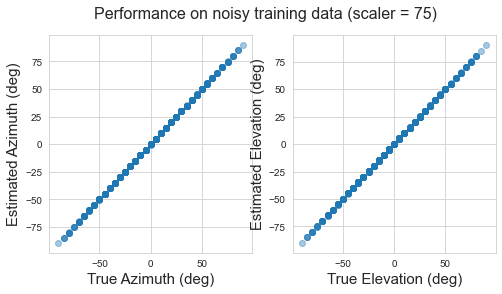

Azimuth RMSE: 0.080400
Elevation RMSE: 0.067200



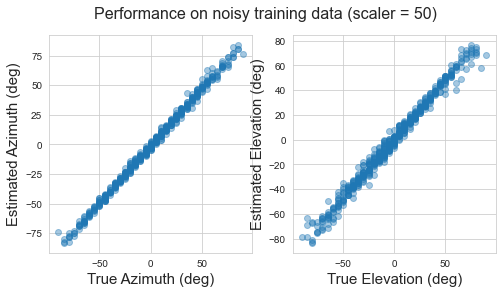

Azimuth RMSE: 2.858200
Elevation RMSE: 4.754800



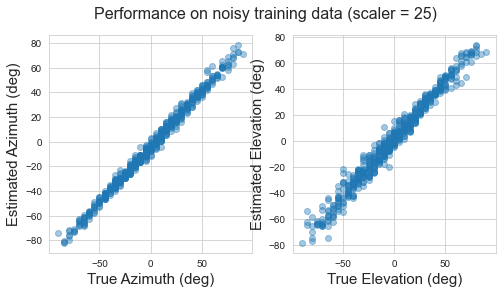

Azimuth RMSE: 5.970600
Elevation RMSE: 7.316100



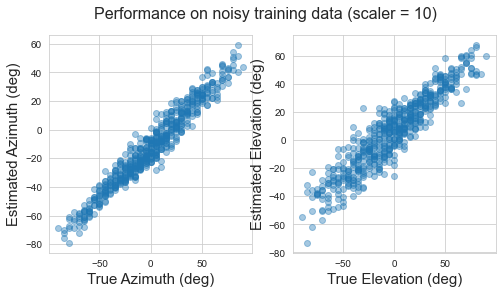

Azimuth RMSE: 17.740000
Elevation RMSE: 18.182400



In [14]:
# predictions on clean training data
PerformanceVisualizer(noisy75NN, X_train, y_train, 0)
print()

# predictions on noisy100 training data
PerformanceVisualizer(noisy75NN, noisy100_X_train, y_train, 100)
print()

# predictions on noisy75 training data (what it was trained on)
PerformanceVisualizer(noisy75NN, noisy75_X_train, y_train, 75)
print()

# predictions on noisy50 training data
PerformanceVisualizer(noisy75NN, noisy50_X_train, y_train, 50)
print()

# predictions on noisy25 training data
PerformanceVisualizer(noisy75NN, noisy25_X_train, y_train, 25)
print()

# predictions on noisy10 training data
PerformanceVisualizer(noisy75NN, noisy10_X_train, y_train, 10)
print()

$\rightarrow$ Analyze the performance of the model trained on noisy75 data on test data with different levels of noise introduced.

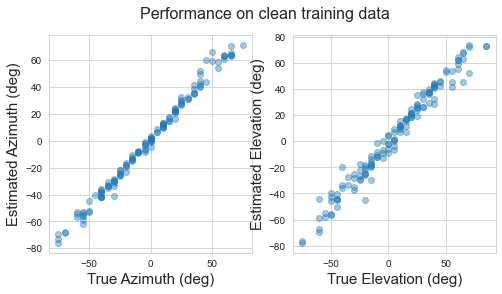

Azimuth RMSE: 3.785600
Elevation RMSE: 6.224400



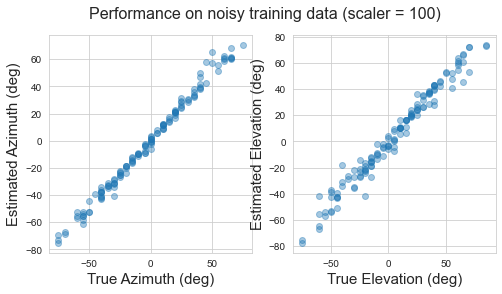

Azimuth RMSE: 3.409600
Elevation RMSE: 6.177900



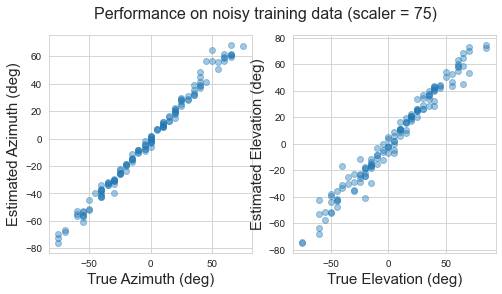

Azimuth RMSE: 3.341200
Elevation RMSE: 6.170400



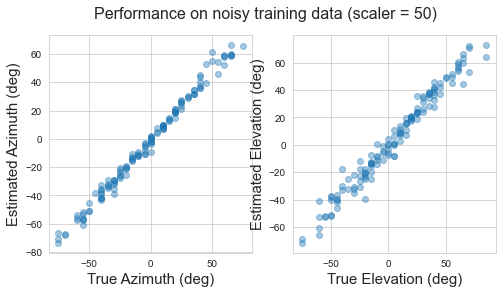

Azimuth RMSE: 3.515400
Elevation RMSE: 6.587400



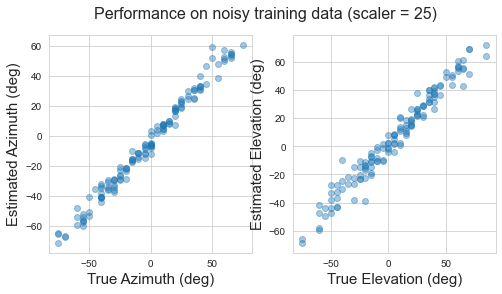

Azimuth RMSE: 5.773600
Elevation RMSE: 8.126400



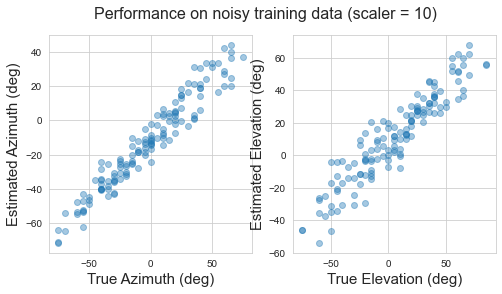

Azimuth RMSE: 16.200300
Elevation RMSE: 16.324600



In [15]:
# predictions on clean testing data 
PerformanceVisualizer(noisy75NN, X_test, y_test, 0)
print()

# predictions on noisy100 testing data
PerformanceVisualizer(noisy75NN, noisy100_X_test, y_test, 100)
print()

# predictions on noisy75 testing data (what it was trained on)
PerformanceVisualizer(noisy75NN, noisy75_X_test, y_test, 75)
print()

# predictions on noisy50 testing data
PerformanceVisualizer(noisy75NN, noisy50_X_test, y_test, 50)
print()

# predictions on noisy25 testing data
PerformanceVisualizer(noisy75NN, noisy25_X_test, y_test, 25)
print()

# predictions on noisy10 testing data
PerformanceVisualizer(noisy75NN, noisy10_X_test, y_test, 10)
print()

$\rightarrow$ Train a neural network on noisy50 training data.

In [16]:
noisy50NN = MLPRegressor(max_iter = 10000).fit(noisy50_X_train, y_train)

$\rightarrow$ Analyze the performance of the model trained on noisy50 on training data with different levels of noise introduced.

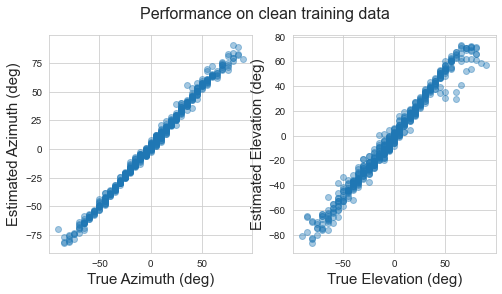

Azimuth RMSE: 4.148200
Elevation RMSE: 5.725900



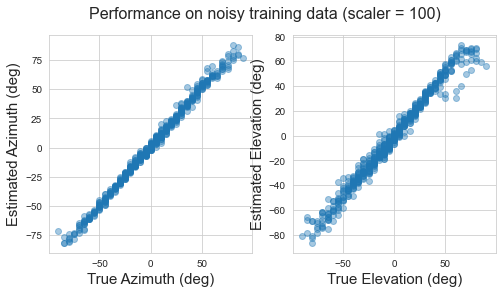

Azimuth RMSE: 3.277300
Elevation RMSE: 5.619700



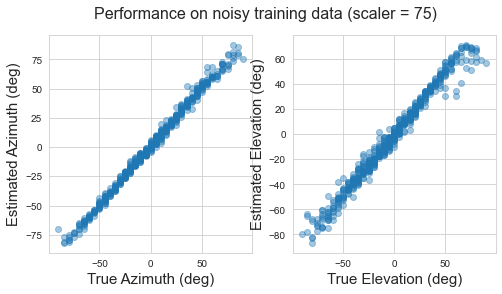

Azimuth RMSE: 3.185500
Elevation RMSE: 5.652700



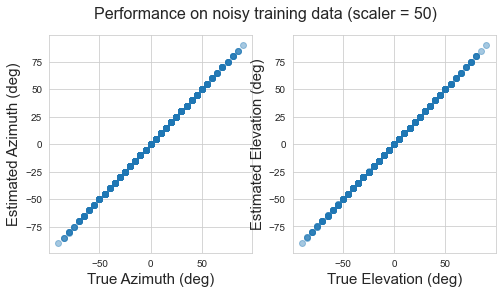

Azimuth RMSE: 0.042400
Elevation RMSE: 0.023500



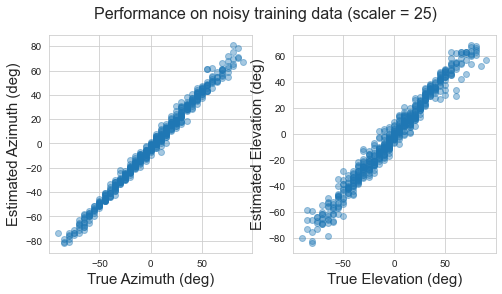

Azimuth RMSE: 5.723900
Elevation RMSE: 7.324200



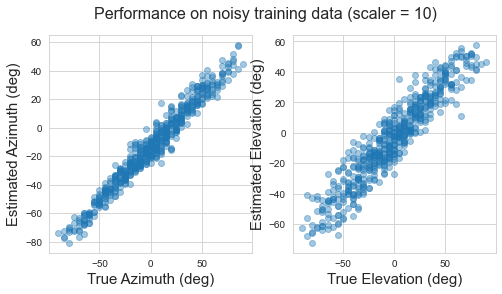

Azimuth RMSE: 17.682900
Elevation RMSE: 14.822300



In [17]:
# predictions on clean training data
PerformanceVisualizer(noisy50NN, X_train, y_train, 0)
print()

# predictions on noisy100 training data
PerformanceVisualizer(noisy50NN, noisy100_X_train, y_train, 100)
print()

# predictions on noisy75 training data
PerformanceVisualizer(noisy50NN, noisy75_X_train, y_train, 75)
print()

# predictions on noisy50 training data (what it was trained on)
PerformanceVisualizer(noisy50NN, noisy50_X_train, y_train, 50)
print()

# predictions on noisy25 training data
PerformanceVisualizer(noisy50NN, noisy25_X_train, y_train, 25)
print()

# predictions on noisy10 training data
PerformanceVisualizer(noisy50NN, noisy10_X_train, y_train, 10)
print()

$\rightarrow$ Analyze the performance of the model trained on noisy50 data on test data with different levels of noise introduced.

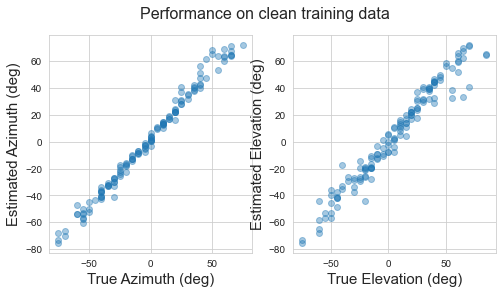

Azimuth RMSE: 5.140400
Elevation RMSE: 7.782200



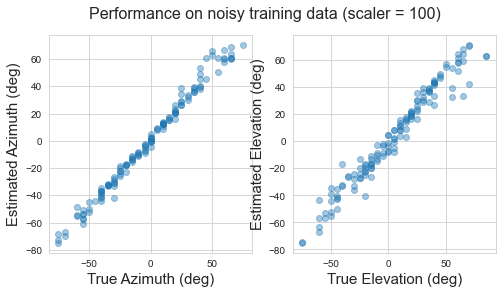

Azimuth RMSE: 4.389600
Elevation RMSE: 7.714600



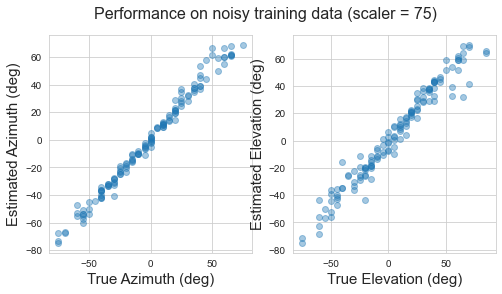

Azimuth RMSE: 4.263500
Elevation RMSE: 7.820300



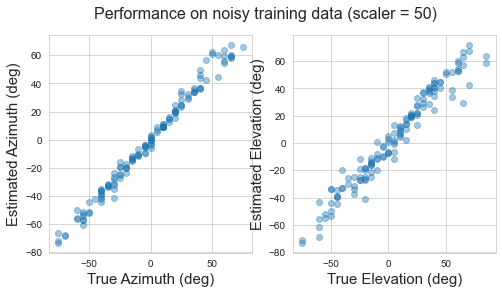

Azimuth RMSE: 4.021000
Elevation RMSE: 8.168300



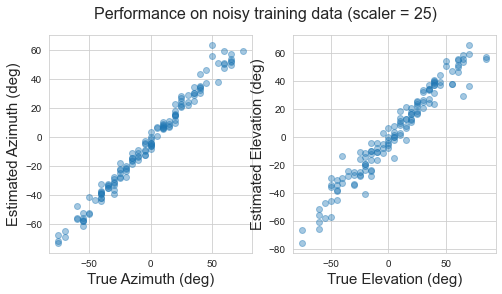

Azimuth RMSE: 5.600600
Elevation RMSE: 9.450200



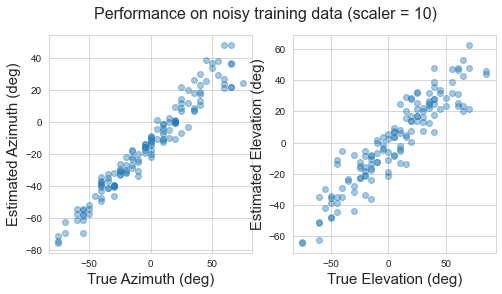

Azimuth RMSE: 16.604600
Elevation RMSE: 16.086000



In [18]:
# predictions on clean testing data 
PerformanceVisualizer(noisy50NN, X_test, y_test, 0)
print()

# predictions on noisy100 testing data
PerformanceVisualizer(noisy50NN, noisy100_X_test, y_test, 100)
print()

# predictions on noisy75 testing data
PerformanceVisualizer(noisy50NN, noisy75_X_test, y_test, 75)
print()

# predictions on noisy50 testing data (what it was trained on)
PerformanceVisualizer(noisy50NN, noisy50_X_test, y_test, 50)
print()

# predictions on noisy25 testing data
PerformanceVisualizer(noisy50NN, noisy25_X_test, y_test, 25)
print()

# predictions on noisy10 testing data
PerformanceVisualizer(noisy50NN, noisy10_X_test, y_test, 10)
print()

$\rightarrow$ Train a neural network on noisy25 training data.

In [19]:
noisy25NN = MLPRegressor(max_iter = 10000).fit(noisy25_X_train, y_train)

$\rightarrow$ Analyze the performance of the model trained on noisy25 on training data with different levels of noise introduced.

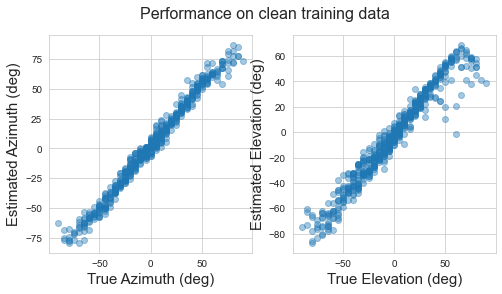

Azimuth RMSE: 5.440600
Elevation RMSE: 8.898300



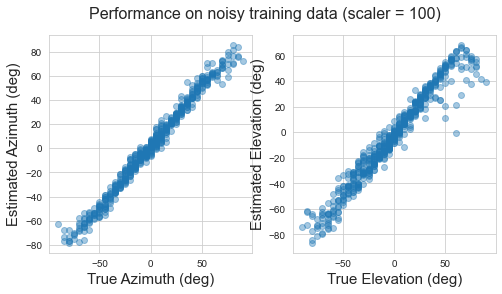

Azimuth RMSE: 5.130100
Elevation RMSE: 8.778100



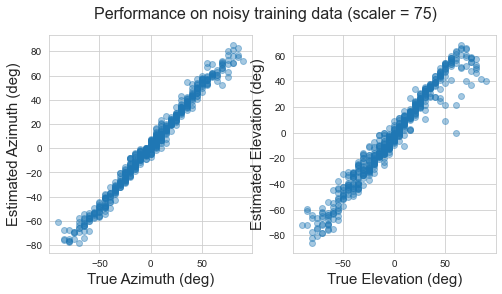

Azimuth RMSE: 5.098100
Elevation RMSE: 8.851300



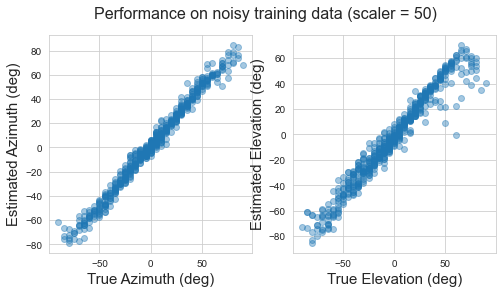

Azimuth RMSE: 5.092200
Elevation RMSE: 8.926100



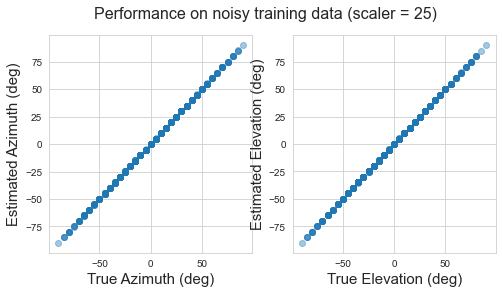

Azimuth RMSE: 0.027000
Elevation RMSE: 0.020000



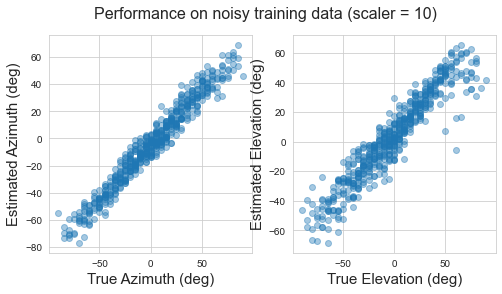

Azimuth RMSE: 11.193900
Elevation RMSE: 15.086500



In [20]:
# predictions on clean training data
PerformanceVisualizer(noisy25NN, X_train, y_train, 0)
print()

# predictions on noisy100 training data
PerformanceVisualizer(noisy25NN, noisy100_X_train, y_train, 100)
print()

# predictions on noisy75 training data
PerformanceVisualizer(noisy25NN, noisy75_X_train, y_train, 75)
print()

# predictions on noisy50 training data
PerformanceVisualizer(noisy25NN, noisy50_X_train, y_train, 50)
print()

# predictions on noisy25 training data (what it was trained on)
PerformanceVisualizer(noisy25NN, noisy25_X_train, y_train, 25)
print()

# predictions on noisy10 training data
PerformanceVisualizer(noisy25NN, noisy10_X_train, y_train, 10)
print()

$\rightarrow$ Analyze the performance of the model trained on noisy25 data on test data with different levels of noise introduced.

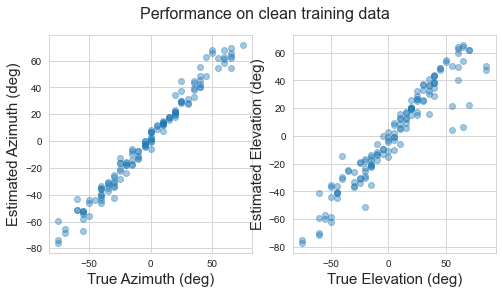

Azimuth RMSE: 6.109400
Elevation RMSE: 12.063100



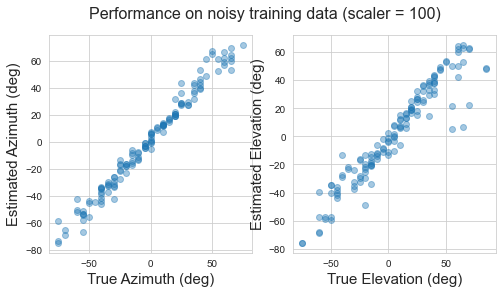

Azimuth RMSE: 5.707000
Elevation RMSE: 11.971600



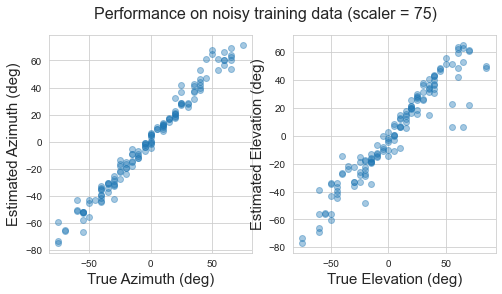

Azimuth RMSE: 5.661500
Elevation RMSE: 11.938800



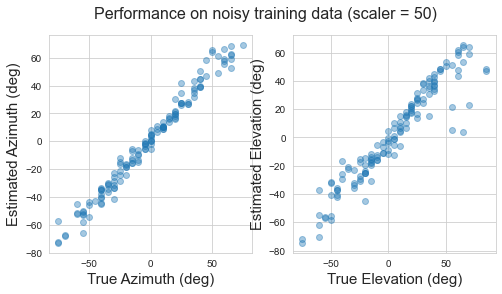

Azimuth RMSE: 5.555300
Elevation RMSE: 12.058200



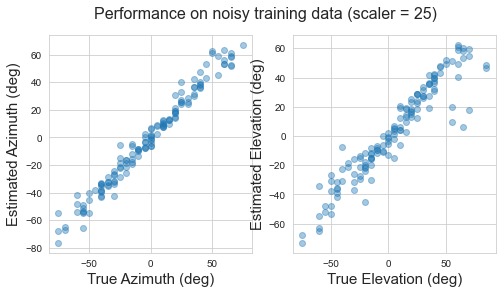

Azimuth RMSE: 6.006400
Elevation RMSE: 12.612700



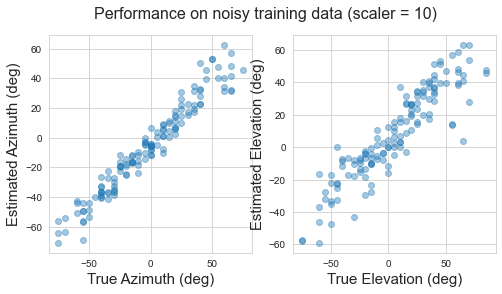

Azimuth RMSE: 10.570800
Elevation RMSE: 16.814900



In [21]:
# predictions on clean testing data 
PerformanceVisualizer(noisy25NN, X_test, y_test, 0)
print()

# predictions on noisy100 testing data
PerformanceVisualizer(noisy25NN, noisy100_X_test, y_test, 100)
print()

# predictions on noisy75 testing data
PerformanceVisualizer(noisy25NN, noisy75_X_test, y_test, 75)
print()

# predictions on noisy50 testing data
PerformanceVisualizer(noisy25NN, noisy50_X_test, y_test, 50)
print()

# predictions on noisy25 testing data (what it was trained on)
PerformanceVisualizer(noisy25NN, noisy25_X_test, y_test, 25)
print()

# predictions on noisy10 testing data
PerformanceVisualizer(noisy25NN, noisy10_X_test, y_test, 10)
print()

$\rightarrow$ Train a neural network on noisy10 training data.

In [22]:
noisy10NN = MLPRegressor(max_iter = 10000).fit(noisy10_X_train, y_train)

$\rightarrow$ Analyze the performance of the model trained on noisy10 on training data with different levels of noise introduced.

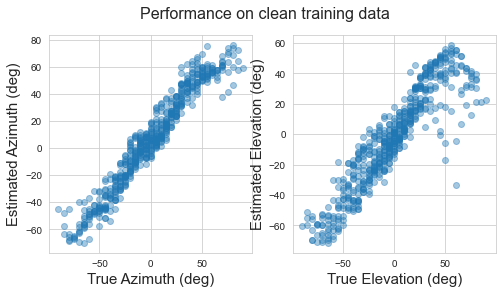

Azimuth RMSE: 11.319300
Elevation RMSE: 15.725700



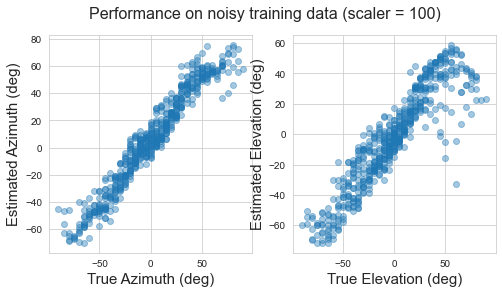

Azimuth RMSE: 11.130700
Elevation RMSE: 15.707100



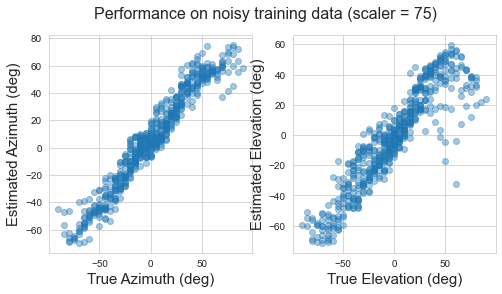

Azimuth RMSE: 11.129000
Elevation RMSE: 15.813500



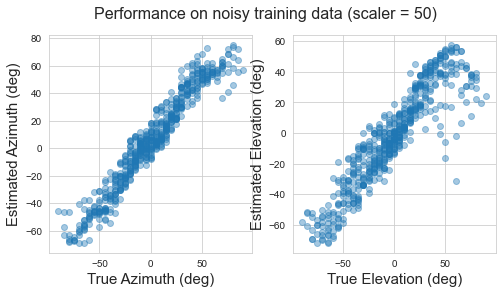

Azimuth RMSE: 11.022600
Elevation RMSE: 15.882100



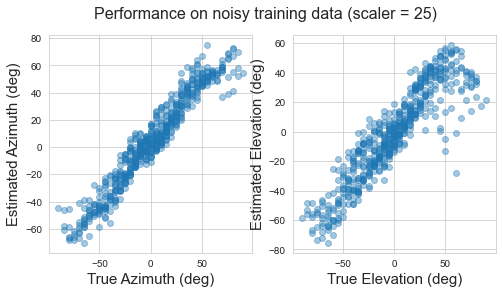

Azimuth RMSE: 10.861800
Elevation RMSE: 16.366100



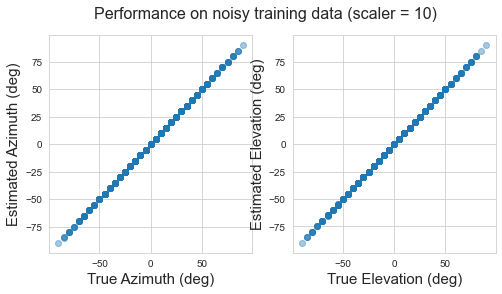

Azimuth RMSE: 0.017600
Elevation RMSE: 0.011200



In [23]:
# predictions on clean training data
PerformanceVisualizer(noisy10NN, X_train, y_train, 0)
print()

# predictions on noisy100 training data
PerformanceVisualizer(noisy10NN, noisy100_X_train, y_train, 100)
print()

# predictions on noisy75 training data
PerformanceVisualizer(noisy10NN, noisy75_X_train, y_train, 75)
print()

# predictions on noisy50 training data
PerformanceVisualizer(noisy10NN, noisy50_X_train, y_train, 50)
print()

# predictions on noisy25 training data 
PerformanceVisualizer(noisy10NN, noisy25_X_train, y_train, 25)
print()

# predictions on noisy10 training data (what it was trained on)
PerformanceVisualizer(noisy10NN, noisy10_X_train, y_train, 10)
print()

$\rightarrow$ Analyze the performance of the model trained on noisy10 data on test data with different levels of noise introduced.

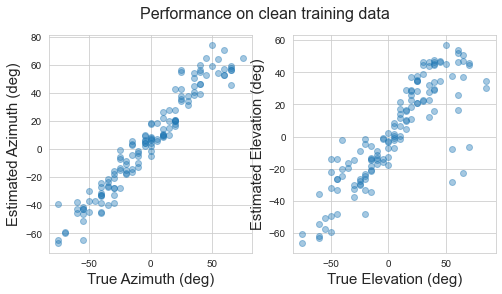

Azimuth RMSE: 11.691600
Elevation RMSE: 19.577900



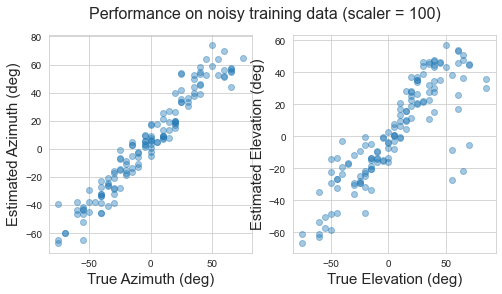

Azimuth RMSE: 11.387300
Elevation RMSE: 19.522800



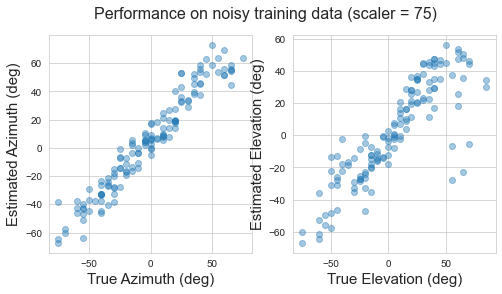

Azimuth RMSE: 11.410300
Elevation RMSE: 19.529000



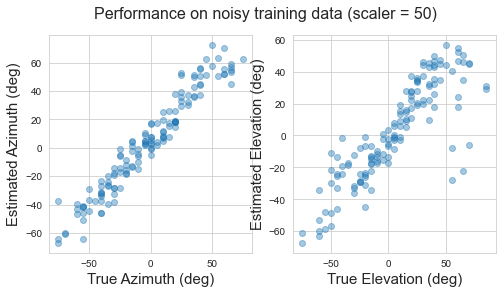

Azimuth RMSE: 11.151700
Elevation RMSE: 19.714500



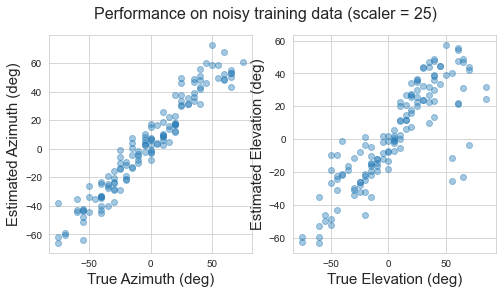

Azimuth RMSE: 10.985300
Elevation RMSE: 20.182100



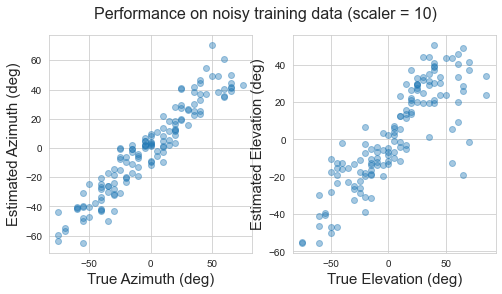

Azimuth RMSE: 12.485000
Elevation RMSE: 20.809300



In [24]:
# predictions on clean testing data 
PerformanceVisualizer(noisy10NN, X_test, y_test, 0)
print()

# predictions on noisy100 testing data
PerformanceVisualizer(noisy10NN, noisy100_X_test, y_test, 100)
print()

# predictions on noisy75 testing data
PerformanceVisualizer(noisy10NN, noisy75_X_test, y_test, 75)
print()

# predictions on noisy50 testing data
PerformanceVisualizer(noisy10NN, noisy50_X_test, y_test, 50)
print()

# predictions on noisy25 testing data
PerformanceVisualizer(noisy10NN, noisy25_X_test, y_test, 25)
print()

# predictions on noisy10 testing data (what it was trained on)
PerformanceVisualizer(noisy10NN, noisy10_X_test, y_test, 10)
print()